# compare All Emulators: SSE; SBE and SSE

In [32]:
import sys, os, glob, pickle, toml, json, pickle, random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.model_selection import GroupKFold,  KFold

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax
    
def get_rmse(d1, d2):
    return ( np.nanmean( (d1-d2)**2 ) ) ** 0.5

def get_cc(d1, d2):
    ind = ~np.isnan(d1+d2)
    return np.corrcoef(d1[ind], d2[ind])[0,1]

def get_nse(obs, sim):     
    return 1-(np.nansum((sim-obs)**2)/np.nansum((obs-np.nanmean(obs))**2))

def get_mae(d1, d2):
    return np.nanmean( np.abs(d1 - d2) )

def combine_cv_test(cv_result):
    dataplot = []
    dinput = np.array([])
    dest = np.array([])
    dindex = np.array([])

    # check if 0 is in
    if 0 in cv_result:
    
        for i in range(len(cv_result)):
            dinput = np.hstack([dinput, np.squeeze(cv_result[i]['y_test'])])
            dest = np.hstack([dest,  np.squeeze(cv_result[i]['y_test_pred'])])
            dindex = np.hstack([dindex,  np.squeeze(cv_result[i]['test_index'])])

    else:

        for i in range(1, len(cv_result)+1):
            dinput = np.hstack([dinput, np.squeeze(cv_result[i]['y_test'])])
            dest = np.hstack([dest,  np.squeeze(cv_result[i]['y_test_pred'])])
            dindex = np.hstack([dindex,  np.squeeze(cv_result[i]['test_index'])])
    
    dd = np.vstack([dindex, dinput, dest]).T
    return dd

# Load data and calculate metric for each basin

In [2]:
# load info
infile_basin_info = f"/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv"
df_info = pd.read_csv(infile_basin_info)

## SSE

In [3]:
# load data

path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

methods1 = ['gpr', 'rf', 'mlp']
methods2 = ['GPR', 'RF' , 'MLP']
numbasin = 627

# cv_est_sse = []
# cv_eval_sse = np.nan * np.zeros([numbasin, 5, 2, 2, 3]) # numbasin; 5 fold; rmse/cc; train/test; gpr/rf/mlp

# for i in range(3):

#     file = f'{path}/SSE_{methods2[i]}_normKGE_CV_estimates.pkl'
#     with open(file, 'rb') as file:
#         cv_est_sse.append( pickle.load(file) )

#     file =  f'{path}/SSE_{methods2[i]}_normKGE_CV_evaluation.npz'
#     dtmp = np.load(file)
#     cv_eval_sse[:,:,0,0,i] = dtmp[f'{methods1[i]}_rmse_train']
#     cv_eval_sse[:,:,0,1,i] = dtmp[f'{methods1[i]}_rmse_test']
#     cv_eval_sse[:,:,1,0,i] = dtmp[f'{methods1[i]}_cc_train']
#     cv_eval_sse[:,:,1,1,i] = dtmp[f'{methods1[i]}_cc_test']

# cv_eval_sse = np.nanmean(cv_eval_sse, axis=1)


cv_eval_sse = np.nan * np.zeros([numbasin, 4, 3]) # numbasin; rmse/cc/mae/nse; gpr/rf/mlp

for i in range(3):

    file = f'{path}/SSE_{methods2[i]}_normKGE_CV_estimates.pkl'
    with open(file, 'rb') as file:
        cv_i = pickle.load(file)

    for j in range(numbasin):
        cv_ij = combine_cv_test( cv_i[j] )

        cv_eval_sse[j, 0, i] = get_rmse(cv_ij[:,1], cv_ij[:,2])
        cv_eval_sse[j, 1, i] = get_cc(cv_ij[:,1], cv_ij[:,2])
        cv_eval_sse[j, 2, i] = get_mae(cv_ij[:,1], cv_ij[:,2])
        cv_eval_sse[j, 3, i] = get_nse(cv_ij[:,1], cv_ij[:,2])

print(cv_eval_sse.shape)

(627, 4, 3)


## LSE

In [4]:
path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

methods1 = ['rf', 'mlp']
methods2 = ['RF', 'MLP']
metprefix = [ ['rf', 'rf_group',  'rf_cluster'], 
             ['mlp', 'mlp_group',  'mlp_cluster']]
types = ['standard', 'group', 'cluster']

cv_est_lse = []

lab = []

for i in range(2):
    for j in range(3):
        lab.append(f'{methods2[i]} {types[j]}')
        
        file = f'{path}/LSE_{methods2[i]}_normKGE_{types[j]}CV_estimates.pkl'
        with open(file, 'rb') as file:
            cv_est_lse.append(pickle.load(file))
        
# cv_est_lse = np.array(cv_est_lse)
# print(cv_est_lse.shape)
print(lab)

['RF standard', 'RF group', 'RF cluster', 'MLP standard', 'MLP group', 'MLP cluster']


In [5]:
file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out/basin_id_forinput.gz'
df_basinid = pd.read_csv(file, compression='gzip')

cv_eval_lse = np.nan * np.zeros([len(df_info), 4, len(cv_est_lse)]) # rmse/cc/mae/nse; ['RF standard', 'RF group', 'RF cluster', 'MLP standard', 'MLP group', 'MLP cluster']

for cc in range(len(cv_est_lse)):
    cvi = cv_est_lse[cc]
    
    dataplot = []
    dinput = np.array([])
    dest = np.array([])
    dindex = np.array([])
    for i in range(len(cvi)):
        dinput = np.hstack([dinput, np.squeeze(cvi[i]['y_test'])])
        dest = np.hstack([dest,  np.squeeze(cvi[i]['y_test_pred'])])
        dindex = np.hstack([dindex,  np.squeeze(cvi[i]['test_index'])])
    
    dd = np.vstack([dindex, dinput, dest]).T
    ind = np.argsort(dindex)
    dd = dd[ind, :]
    if len(dd) != (dd[-1,0]-dd[0,0]+1):
        print('Warning! error')
    
    
    for i in range(len(df_info)):
        indi = np.where(df_basinid['basin_id'].values==i)[0]
        ddi = dd[indi, :]
        cv_eval_lse[i, 0, cc] = get_rmse(ddi[:,1], ddi[:,2])
        cv_eval_lse[i, 1, cc] = get_cc(ddi[:,1], ddi[:,2])
        cv_eval_lse[i, 2, cc] = get_mae(ddi[:,1], ddi[:,2])
        cv_eval_lse[i, 3, cc] = get_nse(ddi[:,1], ddi[:,2])

## SBE

In [6]:
# load data

path = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out'

methods1 = ['rf', 'mlp']
methods2 = ['RF', 'MLP']
metprefix = [ ['rf', 'rf_group', ], 
             ['mlp', 'mlp_group', ]]
types = ['standard', 'group']


cv_est_sbe = []
lab = []
for i in range(2):
    for j in range(2):
        cv_est_ij = np.zeros([0, 4])
        lab.append(f'{methods2[i]} {types[j]}')
        for c in range(15):
            
            file = f'{path}/SBE_cluster{c}_{methods2[i]}_normKGE_{types[j]}CV_estimates.pkl'
            with open(file, 'rb') as file:
                cvc = combine_cv_test(pickle.load(file))
                cvc = np.hstack([np.ones([cvc.shape[0], 1]) * c, cvc])
                cv_est_ij = np.vstack([cv_est_ij, cvc])
        
        ind = np.argsort(cv_est_ij[:,1])
        cv_est_ij = cv_est_ij[ind, :]
        cv_est_sbe.append(cv_est_ij)

cv_est_sbe = np.array(cv_est_sbe)
print(lab)
print(cv_est_sbe.shape)

['RF standard', 'RF group', 'MLP standard', 'MLP group']
(4, 247491, 4)


In [7]:
# load cluster information
infile = "../../camels_cluster/Manuela_Brunner_2020/flood_cluster_memberships_CAMELS.txt"
df_cluster = pd.read_csv(infile)
df_cluster = df_cluster.rename(
    columns={"Camels_IDs": "hru_id", "flood_cluster": "clusters"}
)
df_cluster2 = pd.DataFrame()

for id in df_info["hru_id"].values:
    dfi = df_cluster.loc[df_cluster["hru_id"] == id]
    df_cluster2 = pd.concat([df_cluster2, dfi])

df_cluster2.sel_index = np.arange(len(df_cluster2))
df_cluster = df_cluster2
del df_cluster2
df_cluster["clusters"] = df_cluster["clusters"] - 1  # starting from 0

if np.any(df_info["hru_id"].values - df_cluster['hru_id'].values != 0):
    print("Mistmatch between basins and clusters")
else:
    print("basins and clusters match")

basins and clusters match


/glade/derecho/scratch/guoqiang/tmp/ipykernel_63038/3393541547.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_cluster2.sel_index = np.arange(len(df_cluster2))


In [8]:
file = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_MOASMO_bigrange/LargeSampleEmulator_exps_out/basin_id_forinput.gz'
df_basinid = pd.read_csv(file, compression='gzip')

clusters = np.nan * np.zeros(len(df_basinid))
for i in range(len(df_info)):
    indi = df_basinid['basin_id'].values == i
    clusters[indi] = df_cluster.iloc[i]['clusters']

In [9]:

def get_group_cv_indices(df_basinid, nfold=5, rndseed=1234567890):

    random.seed(rndseed)
    np.random.seed(rndseed)

    # Initialize GroupKFold
    group_kfold = GroupKFold(n_splits=nfold)

    # Dictionary to store train and test indices
    group_cv_indices = {}

    # Cross-validation process to save indices
    # does not depend on random seeds
    for fold, (train_index, test_index) in enumerate(group_kfold.split(df_basinid, groups=df_basinid['basin_num'])):
        
        train_basin = np.unique(df_basinid.iloc[train_index]['basin_id'].values)
        test_basin = np.unique(df_basinid.iloc[test_index]['basin_id'].values)

        group_cv_indices[fold] = {'train_index': train_index, 'test_index': test_index, 'train_index_raw': df_basinid.iloc[train_index].index, 'test_index_raw': df_basinid.iloc[test_index].index} 
    return group_cv_indices

# Get the indices
nfold = 5
group_cv_indices_all = []


for usecluster in range(15): # 0-14: 15 clusters
    ind2 = clusters == usecluster
    df_basinid_c = df_basinid[ind2]
    group_cv_indices = get_group_cv_indices(df_basinid_c, nfold)

    group_cv_indices_all.append(group_cv_indices)

In [10]:

cv_est_2 = cv_est_sbe.copy()
trueindex = np.nan * np.zeros(cv_est_2.shape[1])
for i in range(15):
    group_cv_indices = group_cv_indices_all[i]
    indi = cv_est_2[0,:,0]==i
    falseindex_i = cv_est_2[0,:,1][indi]
    trueindex_i = np.nan * np.ones(len(falseindex_i))
    for j in range(5):
        ind1 = group_cv_indices[j]['test_index']
        ind2 = np.array(group_cv_indices[j]['test_index_raw'])
        if np.any( np.any(falseindex_i[ind1] - ind1 !=0) ):
            print('Error warning!')
        trueindex_i[ind1] = ind2
    trueindex[indi] = trueindex_i

for i in range(cv_est_2.shape[0]):
    cv_est_2[i, :, 1] = trueindex

In [11]:
cv_eval_sbe = np.nan * np.zeros([len(df_info), 4, cv_est_2.shape[0]]) # rmse/cc/mae/nse; ['RF standard', 'RF group', 'MLP standard', 'MLP group']

for i in range(len(df_info)):
    indi = np.where(df_basinid['basin_id'].values==i)[0]
    for j in range(cv_est_2.shape[0]):
        ddi = cv_est_2[j, indi, 2]
        cv_eval_sbe[i, 0, j] = get_rmse(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])
        cv_eval_sbe[i, 1, j] = get_cc(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])
        cv_eval_sbe[i, 2, j] = get_mae(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])
        cv_eval_sbe[i, 3, j] = get_nse(cv_est_2[j, indi, 2],  cv_est_2[j, indi, 3])

# Box plot of various emulators

In [12]:
# rmse and cc from cv

# for sse, just gpr
df1_1 = pd.DataFrame({
    'rmse': cv_eval_sse[:, 0, 0], # numbasin; rmse/cc; gpr/rf/mlp
    'cc': cv_eval_sse[:, 1, 0],
    'mae': cv_eval_sse[:, 2, 0], # numbasin; rmse/cc; gpr/rf/mlp
    'nse': cv_eval_sse[:, 3, 0],
    'Emulator': 'SSE: GPR',
    'CV': 'Standard CV'
})


# for sse, combine GPR+RF
rmse_sse = np.zeros(cv_eval_sse.shape[0])
cc_sse = np.zeros(cv_eval_sse.shape[0])
mae_sse = np.zeros(cv_eval_sse.shape[0])
nse_sse = np.zeros(cv_eval_sse.shape[0])
induse_rf = cv_eval_sse[:, 0, 0] > cv_eval_sse[:, 0, 1]
rmse_sse[induse_rf] = cv_eval_sse[induse_rf, 0, 1]
rmse_sse[~induse_rf] = cv_eval_sse[~induse_rf, 0, 0]
cc_sse[induse_rf] = cv_eval_sse[induse_rf, 1, 1]
cc_sse[~induse_rf] = cv_eval_sse[~induse_rf, 1, 0]
mae_sse[induse_rf] = cv_eval_sse[induse_rf, 2, 1]
mae_sse[~induse_rf] = cv_eval_sse[~induse_rf, 2, 0]
nse_sse[induse_rf] = cv_eval_sse[induse_rf, 3, 1]
nse_sse[~induse_rf] = cv_eval_sse[~induse_rf, 3, 0]


df1_2 = pd.DataFrame({
    'rmse': rmse_sse, 
    'cc': cc_sse,
    'mae': mae_sse, 
    'nse': nse_sse,
    'Emulator': 'SSE: GPR+RF',
    'CV': 'Standard CV'
})

# cv_eval_lse  # rmse/cc; ['RF standard', 'RF group', 'RF cluster', 'MLP standard', 'MLP group', 'MLP cluster']
df2 = pd.DataFrame({
    'rmse': cv_eval_lse[:, 0, 0],
    'cc': cv_eval_lse[:, 1, 0],
    'mae': cv_eval_lse[:, 2, 0],
    'nse': cv_eval_lse[:, 3, 0],
    'Emulator': 'LSE',
    'CV': 'Standard CV'
})

df3 = pd.DataFrame({
    'rmse': cv_eval_lse[:, 0, 1],
    'cc': cv_eval_lse[:, 1, 1],
    'mae': cv_eval_lse[:, 2, 1],
    'nse': cv_eval_lse[:, 3, 1],
    'Emulator': 'LSE',
    'CV': 'Group CV'
})

df4 = pd.DataFrame({
    'rmse': cv_eval_lse[:, 0, 2],
    'cc': cv_eval_lse[:, 1, 2],
    'mae': cv_eval_lse[:, 2, 2],
    'nse': cv_eval_lse[:, 3, 2],
    'Emulator': 'LSE',
    'CV': 'Cluster CV'
})

# cv_eval_sbe # rmse/cc; ['RF standard', 'RF group', 'MLP standard', 'MLP group']
df5 = pd.DataFrame({
    'rmse': cv_eval_sbe[:, 0, 0],
    'cc': cv_eval_sbe[:, 1, 0],
    'mae': cv_eval_sbe[:, 2, 0],
    'nse': cv_eval_sbe[:, 3, 0],
    'Emulator': 'SBE',
    'CV': 'Standard CV'
})

df6 = pd.DataFrame({
    'rmse': cv_eval_sbe[:, 0, 1],
    'cc': cv_eval_sbe[:, 1, 1],
    'mae': cv_eval_sbe[:, 2, 1],
    'nse': cv_eval_sbe[:, 3, 1],
    'Emulator': 'SBE',
    'CV': 'Group CV'
})

df_plot = pd.concat([df1_1, df1_2, df2, df3, df4, df5, df6])


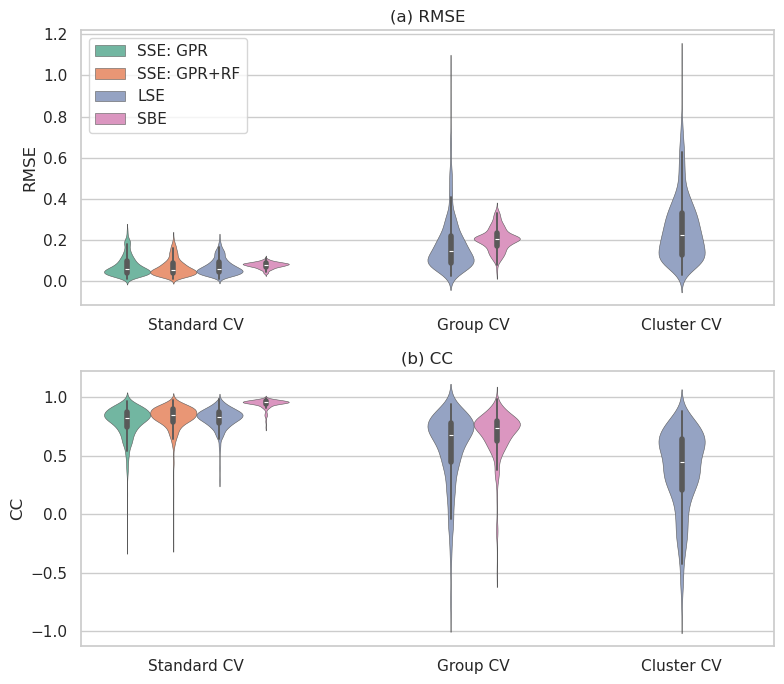

In [13]:

# Create the plot using seaborn
sns.set(style="whitegrid")

titles = ['(a) RMSE', '(b) CC']
ys = ['rmse', 'cc']
ylabs = ['RMSE', 'CC']

fig = plt.figure(figsize=(8, 7))


for i in range(2):
    fig.add_subplot(2, 1, i+1)
    ax = sns.violinplot(data=df_plot, x="CV", y=ys[i], hue="Emulator", palette="Set2", linewidth=0.4, inner='box', inner_kws={'box_width':4},density_norm='width')
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel(ylabs[i])
    ax.set_title(titles[i])
    ax.set_xticks([0, 1.2, 2.1])
    
    # Adjust the legend
    if i == 0:
        plt.legend(loc='upper left')
    else:
        ax.legend().set_visible(False)

# Show the plot
plt.tight_layout()
# plt.savefig('Allemulator_CV_violinplot.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

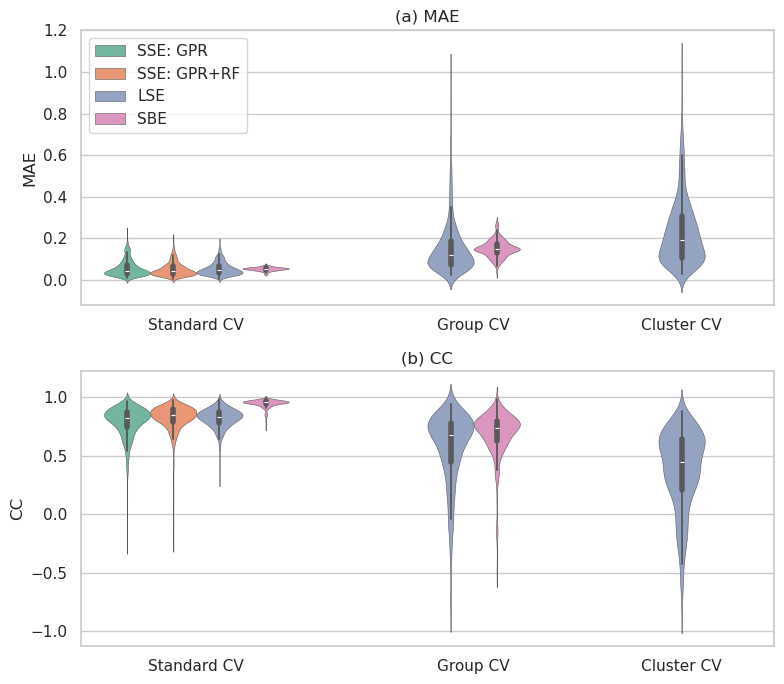

In [15]:

# Create the plot using seaborn
sns.set(style="whitegrid")

titles = ['(a) MAE', '(b) CC']
ys = ['mae', 'cc']
ylabs = ['MAE', 'CC']

fig = plt.figure(figsize=(8, 7))


for i in range(2):
    fig.add_subplot(2, 1, i+1)
    ax = sns.violinplot(data=df_plot, x="CV", y=ys[i], hue="Emulator", palette="Set2", linewidth=0.4, inner='box', inner_kws={'box_width':4},density_norm='width')
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel(ylabs[i])
    ax.set_title(titles[i])
    ax.set_xticks([0, 1.2, 2.1])
    
    # Adjust the legend
    if i == 0:
        plt.legend(loc='upper left')
    else:
        ax.legend().set_visible(False)

# Show the plot
plt.tight_layout()
plt.savefig('Allemulator_CV_violinplot.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# final figure

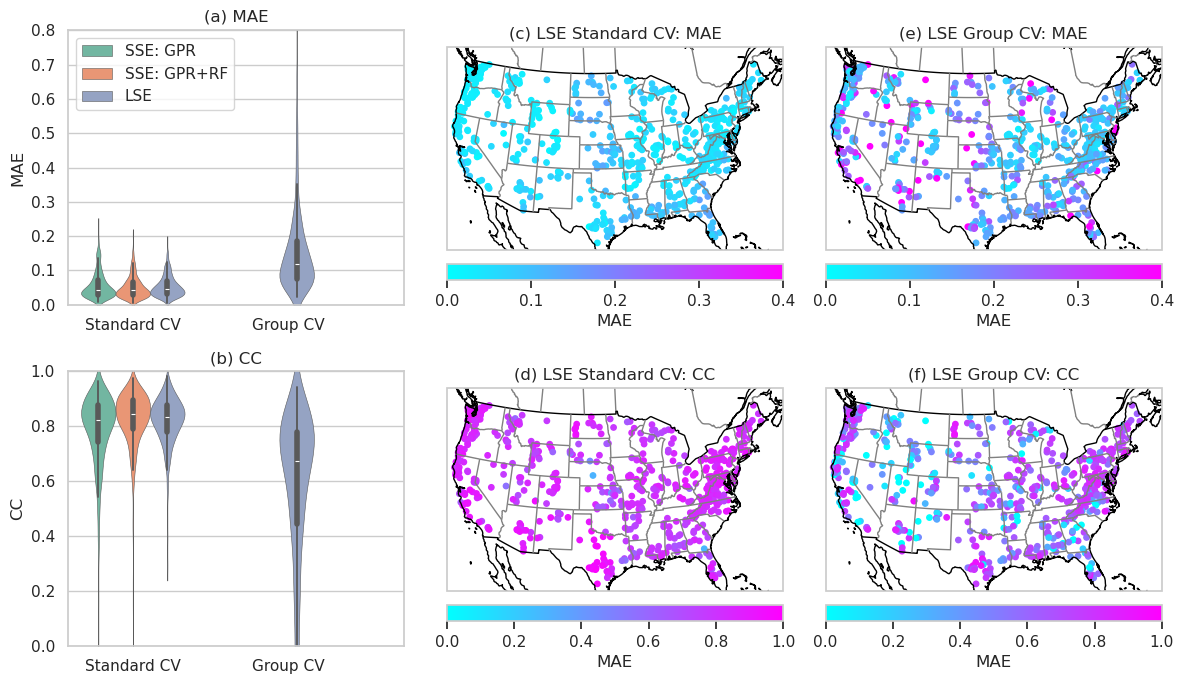

In [49]:
df_plot2 = df_plot.loc[df_plot['Emulator'] != 'SBE']
df_plot2 = df_plot2.loc[df_plot2['CV'] != 'Cluster CV']

# Create the plot using seaborn
sns.set(style="whitegrid")

titles = ['(a) MAE', '(b) CC']
ys = ['mae', 'cc']
ylabs = ['MAE', 'CC']

fig = plt.figure(figsize=(12, 7))

# violin plots
for i in range(2):
    fig.add_subplot(2, 3, i*3+1)
    ax = sns.violinplot(data=df_plot2, x="CV", y=ys[i], hue="Emulator", palette="Set2", linewidth=0.4, inner='box', inner_kws={'box_width':4},density_norm='width')
    # Set the axis labels and title
    ax.set_xlabel("")
    ax.set_ylabel(ylabs[i])
    ax.set_title(titles[i])
    ax.set_xticks([0, 1.2, 2.1])

    if i == 0:
        plt.ylim(0, 0.8)
    else:
        plt.ylim(0, 1)
    
    # Adjust the legend
    if i == 0:
        plt.legend(loc='upper left')
    else:
        ax.legend().set_visible(False)


# spatial map of mae
lon = df_info['lon_cen'].values
lat = df_info['lat_cen'].values
proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(2, 3, 2, projection=proj)
ax = set_background(ax)
data = df_plot2.loc[ (df_plot2['CV'] == 'Standard CV') & (df_plot2['Emulator'] == 'LSE') ]['mae'].values
p = ax.scatter(lon, lat, 15, data, cmap='cool', vmin=0, vmax=0.4, transform=transf)
ax.set_title('(c) LSE Standard CV: MAE')
    
cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='MAE', pad=0.05)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')
# ax.spines['geo'].set_visible(False)


# spatial map of cc
ax = fig.add_subplot(2, 3, 5, projection=proj)
ax = set_background(ax)
data = df_plot2.loc[ (df_plot2['CV'] == 'Standard CV') & (df_plot2['Emulator'] == 'LSE') ]['cc'].values
p = ax.scatter(lon, lat, 15, data, cmap='cool', vmin=0, vmax=1, transform=transf)
ax.set_title('(d) LSE Standard CV: CC')
    
cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='MAE', pad=0.05)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')
# ax.spines['geo'].set_visible(False)


# spatial map of mae
ax = fig.add_subplot(2, 3, 3, projection=proj)
ax = set_background(ax)
data = df_plot2.loc[ (df_plot2['CV'] == 'Group CV') & (df_plot2['Emulator'] == 'LSE') ]['mae'].values
p = ax.scatter(lon, lat, 15, data, cmap='cool', vmin=0, vmax=0.4, transform=transf)
ax.set_title('(e) LSE Group CV: MAE')
    
cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='MAE', pad=0.05)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')
# ax.spines['geo'].set_visible(False)


# spatial map of cc
ax = fig.add_subplot(2, 3, 6, projection=proj)
ax = set_background(ax)
data = df_plot2.loc[ (df_plot2['CV'] == 'Group CV') & (df_plot2['Emulator'] == 'LSE') ]['cc'].values
p = ax.scatter(lon, lat, 15, data, cmap='cool', vmin=0, vmax=1, transform=transf)
ax.set_title('(f) LSE Group CV: CC')
    
cax = plt.colorbar(p, ax=ax, location='bottom', shrink=1, label='MAE', pad=0.05)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')
# ax.spines['geo'].set_visible(False)



# Show the plot
plt.tight_layout()
plt.savefig('SSE_LSE_CV_violinplot_maps.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

In [51]:
for e in ['SSE: GPR', 'SSE: GPR+RF', 'LSE']:
    for c in ['Standard CV', 'Group CV']:
        for m in ['cc', 'mae']:
            data = df_plot2.loc[ (df_plot2['CV'] == c) & (df_plot2['Emulator'] == e) ][m].values
            if len(data)>0:
                print(e, c, m, np.nanmean(data), np.nanmedian(data))

SSE: GPR Standard CV cc 0.7887272745753787 0.8237517328605005
SSE: GPR Standard CV mae 0.0571351770632943 0.044084368069772666
SSE: GPR+RF Standard CV cc 0.8275251142671305 0.8455830660367907
SSE: GPR+RF Standard CV mae 0.05128498039736731 0.042371259696680035
LSE Standard CV cc 0.820653132096825 0.8323330551433067
LSE Standard CV mae 0.05444007095165414 0.0462388050620317
LSE Group CV cc 0.5675504911529358 0.6736025773373769
LSE Group CV mae 0.15487339919384557 0.11915747688996735


In [55]:
for e in ['SSE: GPR', 'SSE: GPR+RF', 'LSE']:
    for c in ['Standard CV', 'Group CV']:
        for m in ['cc']:
            data = df_plot2.loc[ (df_plot2['CV'] == c) & (df_plot2['Emulator'] == e) ][m].values
            if len(data)>0:
                print(e, c, m, np.sum(data<0.5))

SSE: GPR Standard CV cc 22
SSE: GPR+RF Standard CV cc 8
LSE Standard CV cc 5
LSE Group CV cc 182


In [54]:
for e in ['SSE: GPR', 'SSE: GPR+RF', 'LSE']:
    for c in ['Standard CV', 'Group CV']:
        for m in ['mae']:
            data = df_plot2.loc[ (df_plot2['CV'] == c) & (df_plot2['Emulator'] == e) ][m].values
            if len(data)>0:
                print(e, c, m, np.sum(data>0.1)/np.sum(~np.isnan(data)))

SSE: GPR Standard CV mae 0.1371610845295056
SSE: GPR+RF Standard CV mae 0.10047846889952153
LSE Standard CV mae 0.10366826156299841
LSE Group CV mae 0.5885167464114832
